## <center>__MÉTODOS NUMÉRICOS__</center>
## <center>__PROJETO DA UNIDADE 2<br>Remoção de fundo de imagem com PCA Robusto__</center>

### <center>ALUNO: Pedro Henrique Guerra de Abreu</center>

#### **1. INTRODUÇÃO.**

A Análise de Componentes Principais (ACP) ou Principal Component Analysis (PCA) é um procedimento matemático que utiliza uma transformação ortogonal (ortogonalização de vetores) para converter um conjunto de observações de variáveis possivelmente correlacionadas num conjunto de valores de variáveis linearmente não correlacionadas chamadas de componentes principais O número de componentes principais é sempre menor ou igual ao número de variáveis originais. Os componentes principais são garantidamente independentes apenas se os dados forem normalmente distribuídos (conjuntamente). O PCA é sensível à escala relativa das variáveis originais. Dependendo da área de aplicação, o PCA é também conhecido como transformada de Karhunen-Loève (KLT) discreta, transformada de Hotelling ou decomposição ortogonal própria (POD).

#### **2. Descrição do problema.**

A subtração de fundo é usada em diferentes aplicações para detectar os objetos em movimento na cena quando a câmera está estática, como em vigilância por vídeo, captura de movimento óptico e multimídia.
A subtração de fundo apresenta os seguintes problemas

-Escolha do tamanho do recurso: pixel, bloco ou cluster.

-Escolha do tipo de recurso: recursos de cor, recursos de borda, recursos estéreo, recursos de movimento e recursos de textura.

#### **Métodos aplicados a solução.**

Ao lidar com conjuntos de dados de alta dimensão, muitas vezes aproveitamos o fato de que os dados têm baixa dimensionalidade intrínseca para aliviar a maldição da dimensionalidade e escala (talvez esteja em um subespaço de baixa dimensão ou em uma variedade de baixa dimensão ). A análise de componentes principais é útil para eliminar dimensões. O PCA clássico busca a melhor classificação **k** estimativa e **u** do **M**(minimizando∥ **M− L** ∥Ondee **u** tem classificação **-k**). O SVD truncado faz esse cálculo.


O PCA tradicional pode lidar com pequenos ruídos, mas é frágil em relação a observações grosseiramente corrompidas - mesmo uma observação grosseiramente corrompida pode atrapalhar significativamente a resposta.

**O PCA robusto** fatora uma matriz na soma de duas matrizes, **M= L + S**, Onde **M** é a matriz original,e **u** é de **baixo escalão** e **S** é escasso. Isto é o que usaremos para o problema de remoção do plano de fundo. **Baixa classificação** significa que a matriz tem muitas informações redundantes - neste caso, é o plano de fundo, que é o mesmo em todas as cenas (fale sobre informações redundantes!). **Esparso** significa que a matriz tem praticamente zero entradas-- neste caso, veja como a imagem do primeiro plano (as pessoas) está quase vazia. (No caso de dados corrompidos,**S** está capturando as entradas corrompidas).

In [1]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import moviepy.editor as mpe
from IPython.display import display
from glob import glob
from PIL import Image

import sys, os
import scipy
import scipy.misc

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
TOL = 1.0e-8

In [4]:
video = mpe.VideoFileClip("Downloads\ProjetoRemocao.mp4")

In [5]:
video

In [6]:
video.subclip(0,50).ipython_display(width=300)

t:  11%|███████                                                            | 37/350 [00:00<00:00, 369.98it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [7]:
video.duration

50.0

### **Métodos Auxiliáres**

Os métodos abaixo estão disponíveis no link: https://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/3.%20Background%20Removal%20with%20Robust%20PCA.ipynb 

**Descrição dos Métodos Auxiliáres**

1.Definir uma matriz de dados a partir do video.

    def create_data_matrix_from_video(clip, k=5, scale=50):

2.Muda as cores do video para escala de cinza.

    def rgb2gray(rgb):
3.Temos dois métodos para plotar as imagens.

    def plt_images(M, A, E, index_array, dims, filename=None):
    def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):

In [14]:
def create_data_matrix_from_video(clip, k=5, scale=50):
    return np.vstack([np.array(Image.fromarray(rgb2gray(clip.get_frame(i/float(k))).astype(np.uint8)).resize(scale)).flatten() 
                      for i in range(k * int(clip.duration))]).T

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [10]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

In [11]:
def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims), cmap="gray")

# Carregar e visualizar os dados

In [12]:
scale = 25   # Ajusta a escala para alterar resolucao da imagem
dims = (int(240 * (scale/100)), int(320 * (scale/100)))

In [15]:
M = create_data_matrix_from_video(video, 100, (80, 60))
# M = np.load("high_res_surveillance_matrix.npy")

In [16]:
print(dims, M.shape)

(60, 80) (4800, 5000)


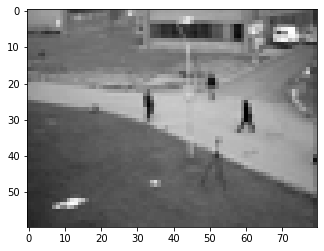

In [17]:
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

Como a função

    def create_data_matrix_from_video(clip, k=5, scale=50):
é um pouco lenta, salvaremos nossa matriz. Em geral, sempre que houver etapas lentas de pré-processamento, é uma boa idéia salvar os resultados para uso futuro.

In [19]:
np.save("low_res_surveillance_matrix.npy", M)

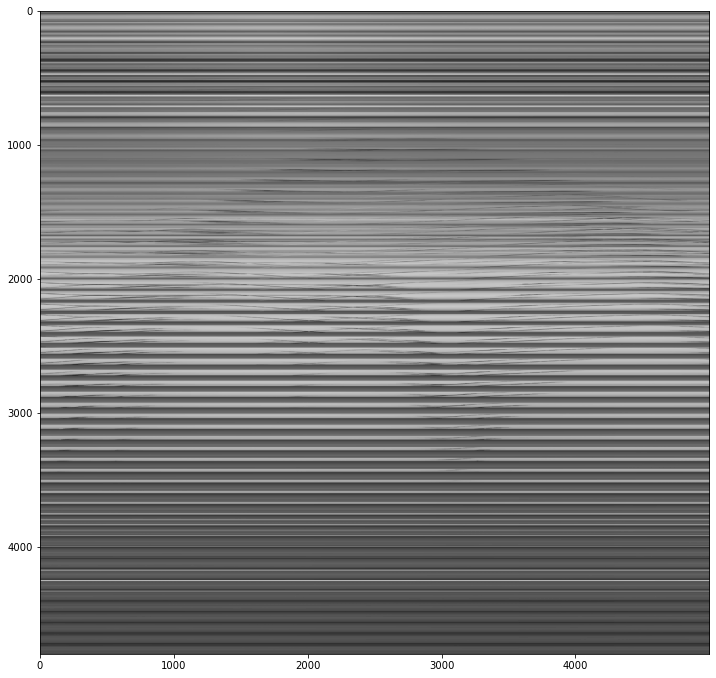

In [20]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

In [21]:
plt.imsave(fname="image1.jpg", arr=np.reshape(M[:,140], dims), cmap='gray')

# Usando SVD

In [22]:
from sklearn import decomposition

In [23]:
u, s, v = decomposition.randomized_svd(M, 2)

In [24]:
u.shape, s.shape, v.shape

((4800, 2), (2,), (2, 5000))

In [25]:
low_rank = u @ np.diag(s) @ v

In [26]:
low_rank.shape

(4800, 5000)

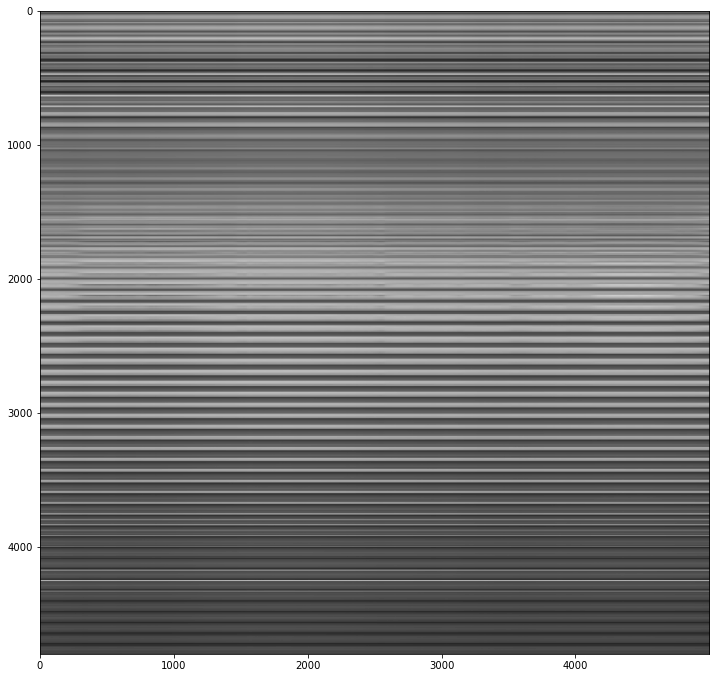

In [27]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

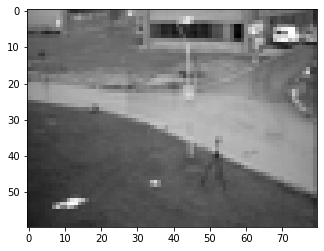

In [28]:
plt.imshow(np.reshape(low_rank[:,140], dims), cmap='gray');

Nesse caso, podemos ver aqui apenas o nosso Background.

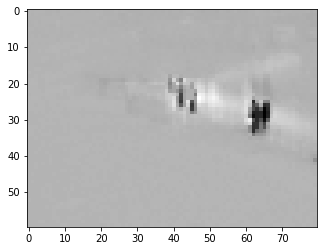

In [31]:
plt.imshow(np.reshape(M[:,550] - low_rank[:,550], dims), cmap='gray');

Nesse caso, podemos ver apenas as pessoas, ou figuras em movimento.

Ao lidar com conjuntos de dados de alta dimensão, geralmente aproveitamos o fato de que os dados têm baixa dimensionalidade intrínseca para aliviar a maldição da dimensionalidade e da escala (talvez esteja em um subespaço de baixa dimensão ou em um coletor de baixa dimensão ) A análise de componentes principais é útil para eliminar dimensões. O PCA clássico busca a melhor estimativa de classificação

para isso,

Usaremos a biblioteca Fast Randomized PCA do Facebook.

In [33]:
pip install fbpca

  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11376 sha256=28ecb2391b8b9cd0afc08324adff85a30635ff50080e39cdc23de44b13953962
  Stored in directory: c:\users\phenr\appdata\local\pip\cache\wheels\b4\3b\77\a06a07a415b222f47a7e522333f85ce64c0defd07a57762267
Successfully built fbpca
Note: you may need to restart the kernel to use updated packages.


In [34]:
from scipy import sparse
from sklearn.utils.extmath import randomized_svd
import fbpca

In [35]:
TOL=1e-9
MAX_ITERS=3

In [36]:
def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

In [37]:
def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

In [38]:
def _svd(M, rank): return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)

In [39]:
def norm_op(M): return _svd(M, 1)[1][0]

In [40]:
def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz

In [42]:
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[140,:], L[140,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples

# Resultados

In [43]:
m, n = M.shape
round(m * .05)

240

In [44]:
L, S, examples =  pcp(M, maxiter=5, k=10)

rank sv: 1
error:  0.1322192434197659
rank sv: 241
error:  0.04033335645092483
rank sv: 43
error:  0.0048781822712997535
rank sv: 283
error:  0.0004050843606253101
rank sv: 523
error:  1.0383773304334338e-05


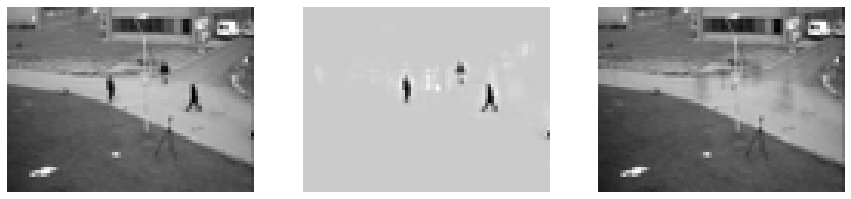

In [45]:
f = plt_images(M, S, L, [140], dims)

In [46]:
np.save("high_res_L.npy", L)
np.save("high_res_S.npy", S)

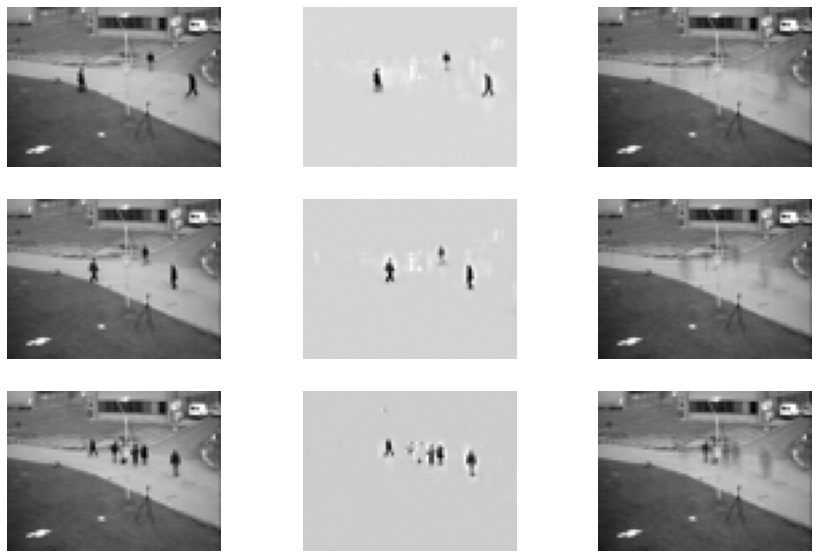

In [47]:
f = plt_images(M, S, L, [0, 100, 1000], dims)